In [29]:
import json
import numpy as np
import pandas as pd
import torch
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
import re
import gensim.downloader as api
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats



In [1]:


# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the JSON data
with open("stories.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract relevant fields
stories = data["stories"]
text_data = []
labels = []

# Preprocess text
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    words = text.split()  # Simple whitespace tokenization
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words if words else ["unk"]  # Handle empty cases

for story in stories:
    text_data.append(preprocess_text(story.get("story", "")))  # Process the story text
    labels.append(story.get("setting", "Unknown"))  # Extract setting as label

# Load pre-trained Word2Vec model using gensim.downloader
print("Loading Word2Vec model...")
word2vec_model = api.load('word2vec-google-news-300')
print("Word2Vec model loaded successfully.")

# Function to get average Word2Vec embeddings
def get_avg_embedding(words, model):
    vectors = [model[word] for word in words if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

# Generate feature vectors
features = np.array([get_avg_embedding(words, word2vec_model) for words in text_data])

# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(set(labels))}
labels_num = np.array([label_map[label] for label in labels])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading Word2Vec model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec model loaded successfully.


SVM Classifier Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        27
           1       0.96      0.96      0.96        26
           2       1.00      0.56      0.71        27
           3       0.69      0.90      0.78        20
           4       0.68      0.81      0.74        21

    accuracy                           0.80       121
   macro avg       0.82      0.81      0.80       121
weighted avg       0.83      0.80      0.80       121



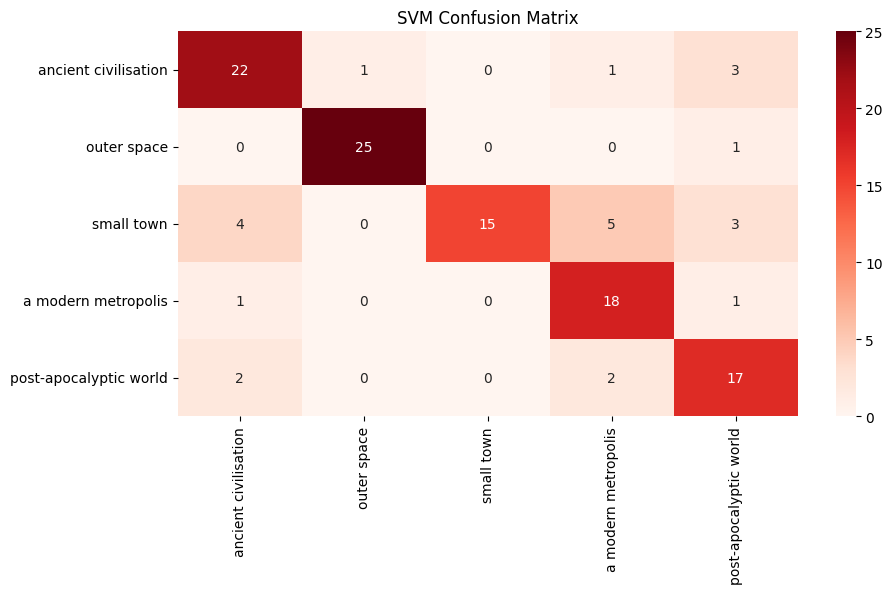

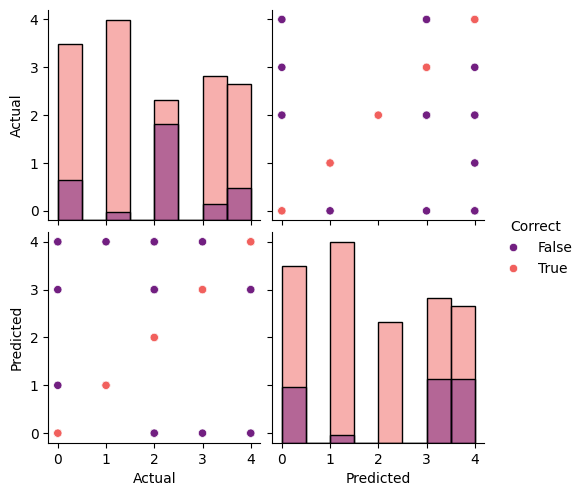

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels_num, test_size=0.2, random_state=42)


#Training a SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)


#Predicting using our SVM
y_pred_svm = svm_model.predict(X_test)


#Classification Report for SVM
print("SVM Classifier Report:")
print(classification_report(y_test, y_pred_svm))


#Confusion Matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Reds', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("SVM Confusion Matrix")
plt.show()

svm_results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svm})
svm_results_df['Correct'] = svm_results_df['Actual'] == svm_results_df['Predicted']
sns.pairplot(svm_results_df, hue='Correct', diag_kind='hist',palette='magma')
plt.show()

Hyperparameter Tuned SVM

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 1000.0}
 Optimized SVM Model Accuracy: 0.9091

 Optimized SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.92      0.92      0.92        26
           2       0.96      1.00      0.98        27
           3       0.89      0.80      0.84        20
           4       0.87      0.95      0.91        21

    accuracy                           0.91       121
   macro avg       0.91      0.91      0.90       121
weighted avg       0.91      0.91      0.91       121



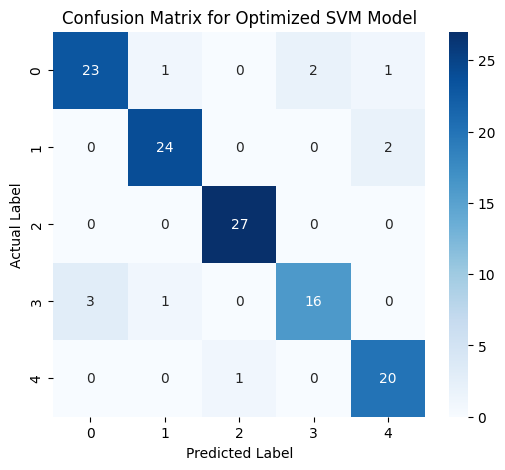

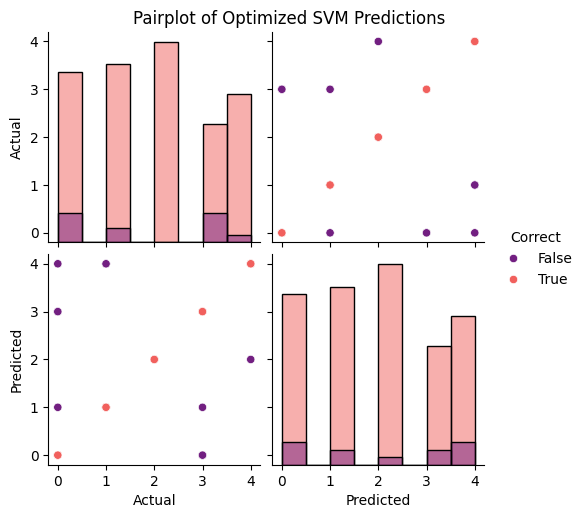

In [19]:


# Hyperparameter grid for tuning
param_grid = {
    'C': np.logspace(-3, 3, 10),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
}

# SVM model
svm_model = SVC(random_state=42)

# Use RandomizedSearchCV for tuning
random_search = RandomizedSearchCV(
    svm_model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42
)

# Fit the randomized search model
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

# Making predictions
y_pred_best_svm = best_model.predict(X_test)

print(f"Best Hyperparameters: {random_search.best_params_}")

#Calculating accuracy
svm_accuracy = accuracy_score(y_test, y_pred_best_svm)
print(f" Optimized SVM Model Accuracy: {accuracy:.4f}")

print("\n Optimized SVM Classification Report:")
print(classification_report(y_test, y_pred_best_svm))

cm = confusion_matrix(y_test, y_pred_best_svm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Optimized SVM Model")
plt.show()

svm_results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best_svm})
svm_results_df['Correct'] = svm_results_df['Actual'] == svm_results_df['Predicted']

# Pairplot
sns.pairplot(svm_results_df, hue='Correct', diag_kind='hist', palette='magma')
plt.suptitle("Pairplot of Optimized SVM Predictions", y=1.02)
plt.show()


In [22]:


# Extract relevant fields
stories = data["stories"]
story_list = [story.get("story", "") for story in stories]
settings = [story.get("setting", "Unknown") for story in stories]

# Convert settings to numerical labels
setting_to_label = {setting: idx for idx, setting in enumerate(set(settings))}
labels = [setting_to_label[setting] for setting in settings]

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(setting_to_label))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize the stories and truncate to max length (512 tokens)
class StoryDataset(Dataset):
    def __init__(self, stories, labels, tokenizer, max_length=512):
        self.stories = stories
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.stories)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.stories[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create dataset and dataloader
dataset = StoryDataset(story_list, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Fine-tune BERT
optimizer = AdamW(model.parameters(), lr=2e-5)
scaler = GradScaler()
model.train()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

# Evaluate the fine-tuned BERT model
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(labels.cpu().tolist())

# Convert numerical labels back to setting names
label_to_setting = {idx: setting for setting, idx in setting_to_label.items()}
y_pred = [label_to_setting[pred] for pred in y_pred]
y_true = [label_to_setting[true] for true in y_true]






Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-22-e173a9d1a664>:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-22-e173a9d1a664>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-24-bf3877f24c68>:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-24-bf3877f24c68>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


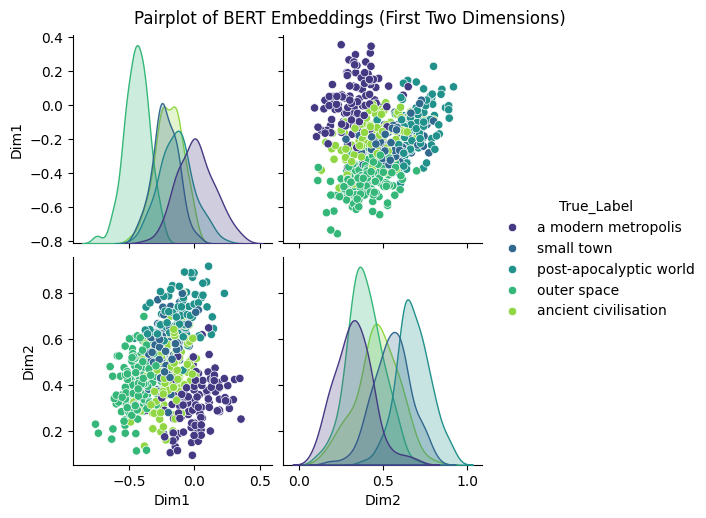

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       124
           1       0.99      0.99      0.99       145
           2       0.98      0.90      0.94       105
           3       0.98      0.97      0.98       115
           4       0.90      0.92      0.91       113

    accuracy                           0.96       602
   macro avg       0.96      0.95      0.95       602
weighted avg       0.96      0.96      0.96       602

Accuracy: 0.9551


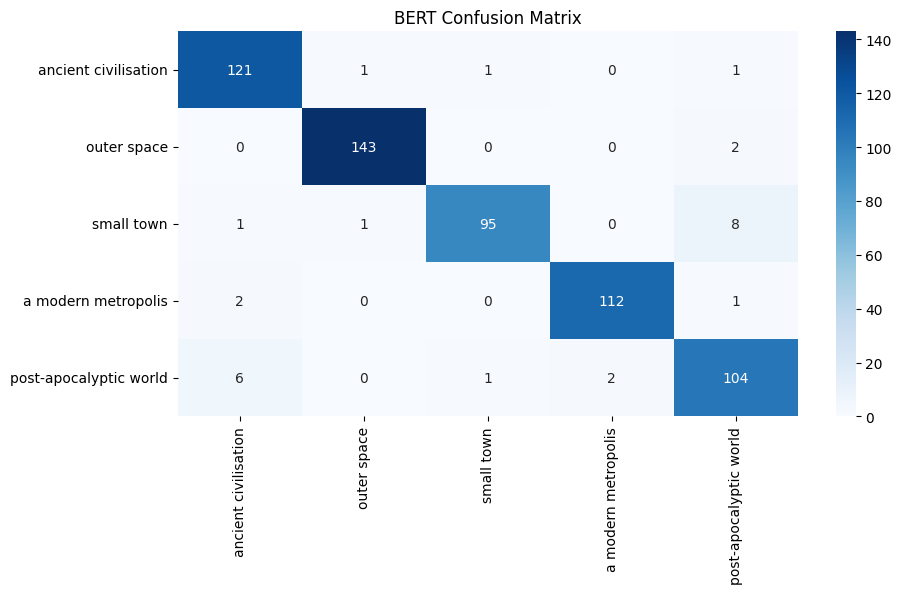

In [24]:


# Extract relevant fields
stories = data["stories"]
story_list = [story.get("story", "") for story in stories]
settings = [story.get("setting", "Unknown") for story in stories]

# Convert settings to numerical labels
setting_to_label = {setting: idx for idx, setting in enumerate(set(settings))}
labels = [setting_to_label[setting] for setting in settings]

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(setting_to_label))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize the stories and truncate to max length (512 tokens)
class StoryDataset(Dataset):
    def __init__(self, stories, labels, tokenizer, max_length=512):
        self.stories = stories
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.stories)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.stories[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create dataset and dataloader
dataset = StoryDataset(story_list, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Fine-tune BERT
optimizer = AdamW(model.parameters(), lr=2e-5)
scaler = GradScaler()
model.train()

for epoch in range(1):
    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_hidden_states=True)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

# Evaluate the fine-tuned BERT model and extract embeddings
model.eval()
embeddings, y_true, y_pred = [], [], []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Get the model outputs with hidden states
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        logits = outputs.logits
        hidden_states = outputs.hidden_states

        # Use the last layer's embeddings
        last_hidden_state = hidden_states[-1]

        # Pooling the embeddings
        pooled_output = last_hidden_state.mean(dim=1)
        embeddings.extend(pooled_output.cpu().numpy())
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(torch.argmax(logits, dim=1).cpu().tolist())

# Convert embeddings to DataFrame for visualization
embeddings = np.array(embeddings)
df = pd.DataFrame(embeddings[:, :2], columns=['Dim1', 'Dim2'])  # Only using the first two dimensions
df['True_Label'] = [label_to_setting[label] for label in y_true]
df['Pred_Label'] = [label_to_setting[label] for label in y_pred]

# Visualize the embeddings and labels using pairplot
sns.pairplot(df, hue='True_Label', vars=['Dim1', 'Dim2'], palette='viridis', kind='scatter')

plt.suptitle("Pairplot of BERT Embeddings (First Two Dimensions)", y=1.02)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label_to_setting.values(), yticklabels=label_to_setting.values())
plt.title("BERT Confusion Matrix")
plt.show()


<ipython-input-20-06210ea29e55>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


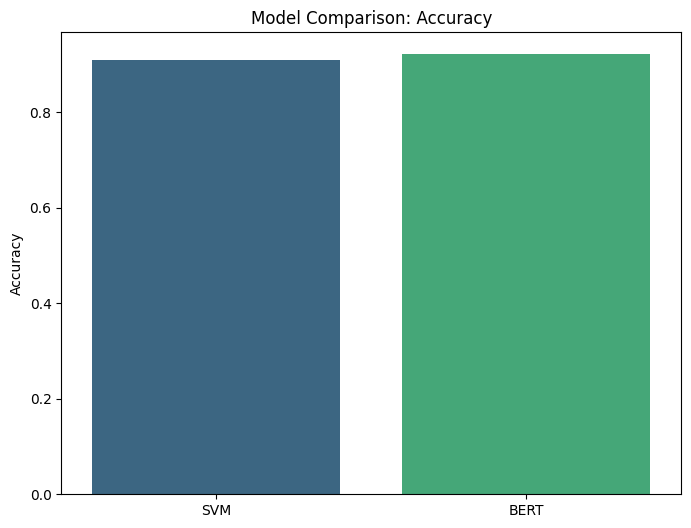

In [20]:
# Comparison with results from Section 2.1


bert_accuracy = accuracy_score(y_true, y_pred)

# Plot comparison
model_names = ['SVM', 'BERT']
accuracies = [svm_accuracy, bert_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Comparison: Accuracy')
plt.ylabel('Accuracy')
plt.show()